# Similarity

In [1]:
import sys
sys.path.append('../')

import os
import geopandas as gpd
import pandas as pd
from common.data import Shapefile
import numpy as np

import common.dataPrep as dataPrep

In [2]:
SHAPEFILE_PATH = 'path/to/file.shp'

In [3]:
# types and possible values of each attribute

def load_shapefile_and_print_unique_values(shapefile_path):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Iterate through each attribute and print unique values or a message
    for column in gdf.columns:
        unique_values = gdf[column].unique()
        if len(unique_values) <= 20:
            print(f"Attribute: {column}, Unique Values: {unique_values}")
        else:
            print(f"Attribute: {column}, More than 10 unique values.")

# load_shapefile_and_print_unique_values(SHAPEFILE_PATH)


In [4]:

from common.dataPrep import *

data_ = load_data(SHAPEFILE_PATH)

In [5]:

data = remove_cols(data_, ['geometry'])

data = replace_null(data, ['Inc',0, 'NaN', '<Nul>'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(data)

# Calculate the percentage of missing and complete data for each column
percent_missing = df.isnull().mean() * 100
percent_complete = 100 - percent_missing

# Plotting
attributes = df.columns
bar_width = 0.35
index = np.arange(len(attributes))

fig, ax = plt.subplots()
bar1 = ax.bar(index, percent_complete, bar_width, label='Complete Data', color='green')
bar2 = ax.bar(index, percent_missing, bar_width, bottom=percent_complete, label='Missing Data', color='red')

ax.set_xlabel('Attributes')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Complete and Missing Data by Attribute')
ax.set_xticks(index)
ax.set_xticklabels(attributes)
ax.set_xticklabels(attributes, rotation='vertical')
ax.legend(loc='lower left', bbox_to_anchor=(0.85, -0.3))  # Place the legend outside the plot on the center left

# plt.tight_layout() 

plt.show()



In [7]:
CURRENT_YEAR = 2020
FIRST_YEAR = 1900

COUNTER = 0

def change_year_interval(data, year_col='ANNEE'):
    """attribute  change all values into valid interval, we have exmpales like '1980-1990': yyyy-yyyy, '1980-': yyyy, '>2000': >yyyy, '<2000': <yyyy\n
    The changes are as follows:\n
        'year1-year2' -> [year1-year2]  \n
        'year' -> [year-year] \n
        '>year' -> ]year-year] \n
        '<year' -> [year-year[
    Args:
        data (_type_): _description_
    """
    counter = 0
    
    # the first 4 digits of int, a function
    def get_first_4_digits(x):
        val = int(x)
        if val > 9999:
            return int(str(val)[:4])
        else:
            return val
    
    
    for i in data.index:
        year_value = data.at[i, year_col]

        if year_value is not None:
            if '-' in year_value:
                years = year_value.split('-')
                data.at[i, year_col] = [(get_first_4_digits(years[0])), get_first_4_digits(years[1])]
                
            elif '>' in year_value:
                year = year_value.split('>')[1]
                data.at[i, year_col] = [get_first_4_digits(year), CURRENT_YEAR]
                
            elif '<' in year_value:
                year = year_value.split('<')[1]
                data.at[i, year_col] = [FIRST_YEAR, get_first_4_digits(year)]
                
            elif year_value.isdigit():
                data.at[i, year_col] = [get_first_4_digits(year_value), get_first_4_digits(year_value)]
            else:
                print('Not supported format {} in row {}'.format(year_value, i))
        counter += 1

    print(counter)
    


change_year_interval(data)

35535


In [8]:
# sub_data = data.head(100).copy()

complet, uncomplet = split2compeleted(data)
print(complet.shape, uncomplet.shape)

sub_data = complet.head(290).copy()

(17578, 8) (17957, 8)


In [9]:
DATA_TYPES = ['NUM', 'CAT', 'INTER']

ATTRIBUTES_TYPES = {
    'COMMUNE': 'CAT',
    'DIAMETRE': 'NUM',
    'ANNEE': 'INTER',
    'MATERIAU': 'CAT',
    'CODE_CONT': 'CAT',
    'MOTRICITE': 'CAT',
    'long': 'NUM',
}

In [10]:
def get_attribute_domain(data, attribute, type):
    # return the unique values of the attribute except the null value
    if type == 'NUM':
        # max and min values
        return [data[attribute].min(), data[attribute].max()]
    elif type == 'CAT':
        return [item for item in data[attribute].unique() if item is not None]
    
    elif type == 'INTER':
        # min_first_element = data[attribute].apply(lambda x: x[0] if x is not None else None).min()
        # max_second_element = data[attribute].apply(lambda x: x[1] if x is not None else None).max()
        
        # print(min_first_element, max_second_element)
        
        # return [min_first_element, max_second_element]
        # data[attribute] is a list of 2 elements, need to return the unique lists
        unique_lists = {
            tuple(sublist)
            for sublist in data[attribute]
            if sublist is not None and any(item is not None for item in sublist)
        }

        return [list(item) for item in unique_lists]
    
    else:
        print('Type {} not supported'.format(type))
        return None


ATTRIBUTES_DOMAIN  = {}

for attribute in ATTRIBUTES_TYPES:
    ATTRIBUTES_DOMAIN[attribute] = get_attribute_domain(data, attribute, ATTRIBUTES_TYPES[attribute])
    
MAX_ANNEE = max([x[1] for x in ATTRIBUTES_DOMAIN['ANNEE'] if x is not None])
MIN_ANNEE = min([x[0] for x in ATTRIBUTES_DOMAIN['ANNEE'] if x is not None])

print(MAX_ANNEE, MIN_ANNEE)

2020 1900


In [11]:
print(ATTRIBUTES_DOMAIN)

{'COMMUNE': ['34077', '34270', '34057', '34116', '34090', '34120', '34172', '34217', '34327', '34169', '34198', '34058', '34129', '34309', '34123', '34192'], 'DIAMETRE': [40.0, 4000.0], 'ANNEE': [[1990, 2000], [2012, 2012], [1998, 1998], [2003, 2003], [2000, 2010], [2008, 2008], [1999, 1999], [2005, 2012], [1900, 1950], [1950, 1960], [1970, 1975], [1960, 1970], [2004, 2004], [2013, 2013], [2010, 2020], [1995, 1995], [2016, 2016], [2014, 2014], [2009, 2009], [2000, 2000], [1985, 1990], [1965, 1975], [2005, 2005], [1950, 2020], [1990, 1995], [2010, 2010], [2001, 2001], [1970, 1980], [1995, 2000], [2006, 2006], [2015, 2015], [1997, 1997], [1992, 1992], [1975, 1985], [2000, 2002], [2000, 2005], [2011, 2011], [2002, 2002], [1985, 1995], [2000, 2020], [1980, 1990], [2007, 2007], [2007, 2013]], 'MATERIAU': ['AC', 'PVC', 'FONTE', 'Gres', 'B', 'Bati', 'PRV', 'ACIER', 'PP', 'BONNA', 'Inox', 'PEHD', 'PE'], 'CODE_CONT': ['J3551', 'HorsRccAss', 'J3601', 'J3561'], 'MOTRICITE': ['GRAVITAIRE', 'REFOUL

### Standard Similarity measues


 D(a, b) = \max_{a' \in [a_1, a_2]} \left( \min_{b' \in [b_1, b_2]} \left( l(a', b') \right) 

In [12]:
def std_numerical_similarity(x, y, domain:list):
    return 1 - abs(x - y) / (domain[1] - domain[0])

def std_categorical_similarity(f_X, f_Y, equals = False):
    # Calculating frequencies
    if equals:
        f_XY = f_X
    else:
        f_XY = f_X + f_Y

    # Avoiding division by zero and log(0) by adding a small number
    epsilon = 1e-9
    f_X += epsilon
    f_Y += epsilon

    # Calculating similarity
    similarity = abs(2 * np.log(f_XY)) / (np.log(f_X) + np.log(f_Y))
    if similarity > 1:
        similarity = 1
    elif similarity < 0:
        similarity = 0
    return similarity

# Overlap Metric for Interval Data

def l(a_prime, b_prime):
    # euclidean distance
    return abs(a_prime - b_prime)

def D(a1, a2, b1, b2):
    c_a = (a1 + a2) / 2
    c_b = (b1 + b2) / 2
    r_a = (a2 - a1) / 2
    r_b = (b2 - b1) / 2
    
    if abs(c_a - c_b <= (r_b - r_a)):
        return 0
    elif abs(c_a - c_b) <= (r_a - r_b):
        return (abs(c_a - c_b) + r_a - r_b)*(1 - 2*r_b/(2*r_a + 1))
    elif r_a == r_b and r_a == 0:
        return abs(c_a - c_b)
    elif abs(r_a - r_b) < abs(c_a - c_b) and abs(c_a - c_b)< (r_a + r_b):
        return (abs(c_a - c_b) + r_a - r_b)*(1 - (r_a + r_b - abs(c_a - c_b))/(2*r_a + 1))
    elif abs(c_a - c_b) >= (r_a + r_b):
        return (abs(c_a - c_b) + r_a - r_b)*(1 + (abs(c_a - c_b) - (r_a + r_b) )/(2*r_a + 1))
        
def O(a1, a2, b1, b2):
    # overlapped area between intervals a and b
    return max(0, min(a2, b2) - max(a1, b1))

def std_interval_similarity(a1, a2, b1, b2, domain:list):
    if a1 > a2:
        raise ValueError("a1 must be less than or equal to a2")
    if b1 > b2:
        raise ValueError("b1 must be less than or equal to b2")
    
    c_a = (a1 + a2) / 2
    c_b = (b1 + b2) / 2
    r_a = (a2 - a1) / 2
    r_b = (b2 - b1) / 2
    max_divergence = abs(MAX_ANNEE - MIN_ANNEE)*(1 + abs(MAX_ANNEE - MIN_ANNEE) / (2 * r_a + 1))

    # Calculate divergence based on interval positions and radii
    if abs(c_a - c_b) <= (r_b - r_a):
        return 1
    elif abs(c_a - c_b) <= (r_a - r_b):
        divergence = (abs(c_a - c_b) + r_a - r_b) * (1 - 2 * r_b / (2 * r_a + 1))
    elif r_a == r_b and r_a == 0:
        divergence = abs(c_a - c_b)
    elif abs(r_a - r_b) < abs(c_a - c_b) and abs(c_a - c_b) < (r_a + r_b):
        divergence = (abs(c_a - c_b) + r_a - r_b) * (1 - (r_a + r_b - abs(c_a - c_b)) / (2 * r_a + 1))
    elif abs(c_a - c_b) >= (r_a + r_b):
        divergence = (abs(c_a - c_b) + r_a - r_b) * (1 + (abs(c_a - c_b) - (r_a + r_b)) / (2 * r_a + 1))
    else:
        divergence = max_divergence

    # Normalize the divergence
    # max_divergence = abs(domain[1] - domain[0])*(1 + abs(domain[1] - domain[0]) / (2 * r_a + 1))
    normalized_divergence = divergence / max_divergence if max_divergence != 0 else 0
    
    if normalized_divergence > 1:
        print('normalized_divergence > 1: {}, max_dvg: {}'.format(normalized_divergence, max_divergence))
        normalized_divergence = 1

    # Convert to similarity
    similarity = 1 - normalized_divergence
    return similarity

TYPE_STD_SIMILARITY = {
    'NUM': std_numerical_similarity,
    'CAT': std_categorical_similarity,
    'INTER': std_interval_similarity
}

### Our Approach

In [13]:
def calculate_frequency(data, attributes_type:dict):
    """
    Calculate the frequency of each unique value in a specified attribute of a DataFrame.

    Args:
    data (pd.DataFrame): DataFrame containing the data.
    attribute (str): The name of the attribute column.

    Returns:
    dict: A dictionary with unique values as keys and their frequencies as values.
    """
    
    frequency_dict = {}
    for attribute in attributes_type:
        if attributes_type[attribute] == 'CAT':
            # Count the occurrences of each unique value in the attribute
            frequency = data[attribute].value_counts()

            # Normalize the counts to get frequencies
            total_count = len(data)
            frequency_dict[attribute] = (frequency / total_count).to_dict()

    return frequency_dict



FREQUENCY_DICT = calculate_frequency(sub_data, ATTRIBUTES_TYPES)


In [14]:



def inter_similarity(a, b, domain=None): #TODO: check this one
    
    if a is None and b is None:
        raise Exception('inter_similarity Exception: All values cannot be None')
    else:
        similarities = []
        if a is None:
            for inter in domain:
                similarities.append(inter_similarity(inter, b, domain) * inter[1] - inter[0])
            return np.mean(similarities)
        
        elif b is None:
            for inter in domain:
                similarities.append(inter_similarity(a, inter, domain))
            return np.mean(similarities)
        else:
            return std_interval_similarity(a[0], a[1], b[0], b[1], domain)
            
    

TYPE_SIMILARITY = {
    'NUM': num_similarity,
    'CAT': cat_similarity,
    'INTER': inter_similarity
}

In [15]:
def remove_random_values(data, percentage, escape_cols=[]):
    """Remove random values from a dataset, maintaining that no row has all missing values.

    Args:
        data (pd.DataFrame): The dataset.
        percentage (float): The percentage of values to remove.
        escape_cols (list): Columns to exclude from random removal.

    Returns:
        pd.DataFrame: The dataset with missing values.
    """
    _data = data.copy()

    # Reset the index of the DataFrame to ensure standard continuous integer indexing
    _data.reset_index(drop=True, inplace=True)

    # Columns that can be modified
    modifiable_columns = [col for col in _data.columns if col not in escape_cols]

    # Calculate the total number of elements to remove
    total_elements = len(modifiable_columns) * len(_data)
    num_elements_to_remove = int(percentage * total_elements)

    removed = 0
    while removed < num_elements_to_remove:
        # Randomly select a row and column
        row_idx = np.random.randint(len(_data))
        col_idx = np.random.choice(modifiable_columns)

        # Check if setting this cell to None would leave the row with all None values
        if not all(pd.isnull(_data.loc[row_idx, modifiable_columns])):
            if _data.at[row_idx, col_idx] is not None:
                _data.at[row_idx, col_idx] = None
                removed += 1

    return _data

def has_missing_values(obj):
    return any([attr is None for attr in obj])

In [16]:

# def find_k_nearest_neighbors(obj_index, data, k, attributes_types, frequency_dict, type_similarity, attr_domains):
#     similarities = []
#     for index in data.index:
#         if index != obj_index:
#             similarity = calculate_similarity(data.iloc[obj_index], data.iloc[index], attributes_types, frequency_dict, type_similarity, attr_domains)
#             similarities.append((index, similarity))
#     similarities.sort(key=lambda x: x[1], reverse=True)
#     return similarities[:k]
    

def calculate_similarity(obj1, obj2, attributes_types, frequency_dict, type_similarity, attr_domain):
    """ Calculate similarity between two objects.
    Args:
        obj1 (dict): First object.
        obj2 (dict): Second object.
        attributes_types (dict): Types of attributes.
        type_similarity (dict): Types of similarity functions.
        attr_domain (dict): Domain of attributes for categorical data.
    """
    
    similarity = []
    for attr in obj1.index:
        if attr in attributes_types:
            if attributes_types[attr] == 'NUM':
                if obj1[attr] is not None or obj2[attr] is not None:
                    sim = type_similarity['NUM'](obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
                
            elif attributes_types[attr] == 'CAT':
                if obj1[attr] is not None or obj2[attr] is not None :
                    sim = type_similarity['CAT'](obj1[attr], obj2[attr], frequency_dict[attr],  attr_domain[attr])
                    # if sim < 0:
                    #     print(obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
                
            elif attributes_types[attr] == 'INTER':
                if obj1[attr] is not None or obj2[attr] is not None:
                    a,b = obj1[attr], obj2[attr]
                    sim = type_similarity['INTER'](a, b, attr_domain[attr])
                    # if sim < 0:
                    #     print(obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
            else:
                print('Not supported type {} for attribute {} of values obj1[{}] = {} and obj2[{}] = {} '.format(attributes_types[attr], attr, attr, obj1[attr], attr, obj2[attr]))
                
    # return np.average(similarity, weights=weights)
    return np.average(similarity) if len(similarity) > 0 else 0

In [17]:
# # Test calculate similarity

# test_data = remove_random_values(sub_data.head(20), 0.8, ['MSLINK'])

# print(test_data)

# test_similarity_matrix = np.zeros((len(test_data), len(test_data)))
# for i in range(len(test_data)):
#     for j in range(len(test_data)):
#         test_similarity_matrix[i, j] = calculate_similarity(test_data.iloc[i], test_data.iloc[j], ATTRIBUTES_TYPES, FREQUENCY_DICT, TYPE_SIMILARITY, ATTRIBUTES_DOMAIN)
        
        
# print(test_similarity_matrix)



In [18]:
def calculate_similarity_vs(obj1, obj2, attributes_types, frequency_dict, type_similarity, attr_domain):
    """ Calculate similarity between two objects.
attribute
    Args:
        obj1 (dict): First object.
        obj2 (dict): Second object.
        attributes_types (dict): Types of attributes.
        type_similarity (dict): Types of similarity functions.
        attr_domain (dict): Domain of attributes for categorical data.
    """
    
    similarity = []
    for attr in obj1.index:
        if attr in attributes_types:
            if attributes_types[attr] == 'NUM' and obj1[attr] is not None and obj2[attr] is not None:
                    sim = type_similarity['NUM'](obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
                
            elif attributes_types[attr] == 'CAT' and obj1[attr] is not None and obj2[attr] is not None:
                    sim = type_similarity['CAT'](obj1[attr], obj2[attr], frequency_dict[attr],  attr_domain[attr])
                    if sim < 0:
                        print(obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
                
            elif attributes_types[attr] == 'INTER' and obj1[attr] is not None and obj2[attr] is not None:
                    sim = type_similarity['INTER'](obj1[attr], obj2[attr], attr_domain[attr])
                    if sim < 0:
                        print(obj1[attr], obj2[attr], attr_domain[attr])
                    similarity.append(sim)
            # else:
                # print('Not supported type {}'.format(attributes_types[attr]))
                
    # return np.average(similarity, weights=weights)
    return  np.average(similarity) if len(similarity) > 0 else 0

In [19]:
from concurrent.futures import ThreadPoolExecutor

def pairwise_similarity(data, metric):
    """Compute the distance matrix for a dataset using multithreading.

    Args:
        data (pd.DataFrame): The dataset.
        metric (func): The distance metric to use.

    Returns:
        np.array: The distance matrix.
    """
    num_data_pts = len(data)
    dist_matrix = np.zeros((num_data_pts, num_data_pts))

    def compute_distance(i, j):
        if i != j:
            dist_matrix[i][j] = metric(data.iloc[i], data.iloc[j])
            dist_matrix[j][i] = dist_matrix[i][j]
        else:
            dist_matrix[i][j] = 0
        

    with ThreadPoolExecutor() as executor:
        # just the upper triangle
        for i in range(num_data_pts):
            for j in range(i, num_data_pts):
                executor.submit(compute_distance, i, j)

    return dist_matrix


In [20]:
def custom_similarity(data_pt1, data_pt2):
    return calculate_similarity(data_pt1, data_pt2, ATTRIBUTES_TYPES, FREQUENCY_DICT, TYPE_SIMILARITY, ATTRIBUTES_DOMAIN)

def custom_similarity_vs(data_pt1, data_pt2):
    return calculate_similarity_vs(data_pt1, data_pt2, ATTRIBUTES_TYPES, FREQUENCY_DICT, TYPE_SIMILARITY, ATTRIBUTES_DOMAIN)


In [21]:
from sklearn.cluster import SpectralClustering
# from sklearn.cluster import HierarchicalClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score

import numpy as np


spectralClustering = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=0)

## Without Messing Data

In [263]:
# Compute pairwise similarities
similarity_matrix = pairwise_similarity(sub_data, metric=custom_similarity)

In [264]:
# Spectral Clustering
clusters = spectralClustering.fit_predict(similarity_matrix)

# % of data points in each cluster
print('Spectral Clustering')
for i in range(5):
    print('Cluster {}: {:.2f}%'.format(i, np.count_nonzero(clusters == i) / len(clusters) * 100))

Spectral Clustering
Cluster 0: 29.00%
Cluster 1: 17.00%
Cluster 2: 8.00%
Cluster 3: 33.00%
Cluster 4: 13.00%


### With 5% of Messing Data

In [ ]:
_5per_missing = remove_random_values(sub_data, 0.05, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])

In [ ]:
my_5per_similarity_matrix = pairwise_similarity(_5per_missing, metric=custom_similarity)

In [ ]:
my_5per_clusters = spectralClustering.fit_predict(my_5per_similarity_matrix)

print('Spectral Clustering with 5% Missing Data')

# cluster: % of data points in each cluster
for i in range(5):
    print('Cluster {}: {:.2f}%'.format(i, np.count_nonzero(my_5per_clusters == i) / len(my_5per_clusters) * 100))

# Comparing using ARI and AMI
ari_score = adjusted_rand_score(clusters, my_5per_clusters)
ami_score = adjusted_mutual_info_score(clusters, my_5per_clusters)

print("Adjusted Rand Index:", ari_score)
print("Adjusted Mutual Information:", ami_score)



In [ ]:
vs_5per_similarity_matrix = pairwise_similarity(_5per_missing, metric=custom_similarity_vs)

In [ ]:
vs_5per_clusters = spectralClustering.fit_predict(vs_5per_similarity_matrix)

print('Spectral Clustering')
# cluster: % of data points in each cluster
for i in range(5):
    print('Cluster {}: {:.2f}%'.format(i, np.count_nonzero(vs_5per_clusters == i) / len(vs_5per_clusters) * 100))

# Comparing using ARI and AMI
ari_score = adjusted_rand_score(clusters, vs_5per_clusters)
ami_score = adjusted_mutual_info_score(clusters, vs_5per_clusters)

print("Adjusted Rand Index:", ari_score)
print("Adjusted Mutual Information:", ami_score)

### With 10% of Messing Data

In [ ]:
_10per_missing = remove_random_values(sub_data, 0.1, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])

In [ ]:
my_10per_similarity_matrix = pairwise_similarity(_10per_missing, metric=custom_similarity)

In [ ]:
my_10per_clusters = spectralClustering.fit_predict(my_10per_similarity_matrix)

print('Spectral Clustering with 10% Missing Data')
# cluster: % of data points in each cluster
for i in range(5):
    print('Cluster {}: {:.2f}%'.format(i, np.count_nonzero(my_10per_clusters == i) / len(my_10per_clusters) * 100))
    
# Comparing using ARI and AMI
ari_score = adjusted_rand_score(clusters, my_10per_clusters)
ami_score = adjusted_mutual_info_score(clusters, my_10per_clusters)

print("Adjusted Rand Index:", ari_score)
print("Adjusted Mutual Information:", ami_score)


In [ ]:
vs_10per_similarity_matrix = pairwise_similarity(_10per_missing, metric=custom_similarity_vs)

In [ ]:
vs_10per_clusters = spectralClustering.fit_predict(vs_10per_similarity_matrix)

print('Spectral Clustering')
# cluster: % of data points in each cluster
for i in range(5):
    print('Cluster {}: {:.2f}%'.format(i, np.count_nonzero(vs_10per_clusters == i) / len(vs_10per_clusters) * 100))
    
# Comparing using ARI and AMI
ari_score = adjusted_rand_score(clusters, vs_10per_clusters)
ami_score = adjusted_mutual_info_score(clusters, vs_10per_clusters)

print("Adjusted Rand Index:", ari_score)
print("Adjusted Mutual Information:", ami_score)

In [ ]:
print(clusters[:30])
print(my_10per_clusters[:30])
print(vs_10per_clusters[:30])

## Main Spetral

In [27]:
mainSpetral = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=0)


similarity_matrix = pairwise_similarity(sub_data, metric=custom_similarity)
clusters_S = mainSpetral.fit_predict(similarity_matrix)

In [26]:
def spectral_clustering(data, per_of_missing):
    
    _per_missing = remove_random_values(data, per_of_missing, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])
    
    _per_similarity_matrix = pairwise_similarity(_per_missing, metric=custom_similarity)
    # replace any Nan or inf with 0
    _per_similarity_matrix = np.nan_to_num(_per_similarity_matrix, nan=0, posinf=0, neginf=0)
    _per_clusters = mainSpetral.fit_predict(_per_similarity_matrix)
    
    per_data_in_clusters = []
    for i in range(5):
        per_data_in_clusters.append(np.count_nonzero(_per_clusters == i) / len(_per_clusters) * 100)
    
    ari_score = adjusted_rand_score(clusters_S, _per_clusters)
    ami_score = adjusted_mutual_info_score(clusters_S, _per_clusters)

    return per_data_in_clusters, ari_score, ami_score

def spectral_clustering_vs(data, per_of_missing):
    
    _per_missing = remove_random_values(data, per_of_missing, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])
    
    vs_per_similarity_matrix = pairwise_similarity(_per_missing, metric=custom_similarity_vs)
    vs_per_clusters = mainSpetral.fit_predict(vs_per_similarity_matrix)
    
    per_data_in_clusters_vs = []
    for i in range(5):
        per_data_in_clusters_vs.append(np.count_nonzero(vs_per_clusters == i) / len(vs_per_clusters) * 100)
    
    aris_score_vs = adjusted_rand_score(clusters_S, vs_per_clusters)
    amis_score_vs = adjusted_mutual_info_score(clusters_S, vs_per_clusters)
    

    return per_data_in_clusters_vs, aris_score_vs, amis_score_vs

def print_results(per_data_in_clusters, ari_score, ami_score):
    print('Spectral Clustering')
    # cluster: % of data points in each cluster
    for i in range(5):
        print('Cluster {}: {:.2f}%'.format(i, per_data_in_clusters[i]))
        
    # Comparing using ARI and AMI
    print("Adjusted Rand Index:", ari_score)
    print("Adjusted Mutual Information:", ami_score)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of percentages from 0 to 80
percentages = np.arange(0, 81, 10)

# Initialize empty lists to store the results for spectral_clustering
ari_scores = []
ami_scores = []

# Initialize empty lists to store the results for spectral_clustering_vs
ari_scores_vs = []
ami_scores_vs = []

# Loop through the percentages and call your functions
for per_of_missing in percentages:
    # Call spectral_clustering and spectral_clustering_vs functions
    per_data, ari, ami = spectral_clustering(sub_data, per_of_missing/100)
    per_data_vs, ari_vs, ami_vs = spectral_clustering_vs(sub_data, per_of_missing/100)
    
    # Append results to respective lists
    ari_scores.append(ari)
    ami_scores.append(ami)
    ari_scores_vs.append(ari_vs)
    ami_scores_vs.append(ami_vs)



/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/sparse/csgraph/_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: array must not contain infs or NaNs

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

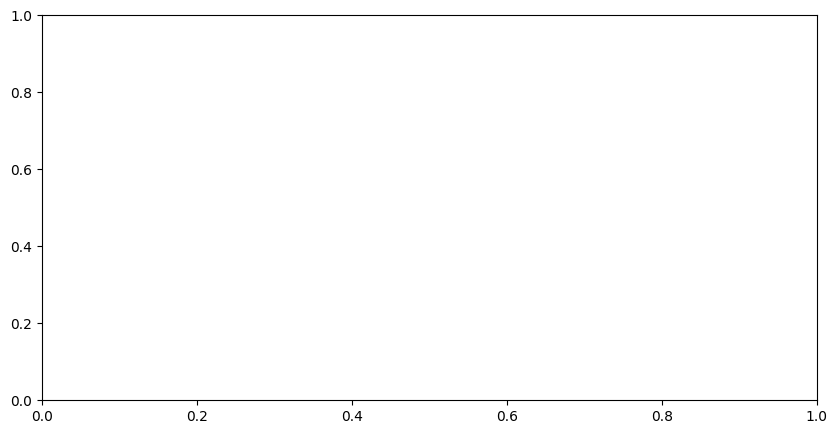

In [25]:

# Create a single plot with both ARI and AMI scores
plt.figure(figsize=(10, 5))

# Plot ARI scores for spectral_clustering_vs
plt.plot(percentages, ari_scores_vs, marker='o', label='ARI Score (Our approach)')

# Plot AMI scores for spectral_clustering_vs
plt.plot(percentages, ami_scores_vs, marker='o', label='AMI Score (Our approach)')

# Plot ARI scores for spectral_clustering
plt.plot(percentages, ari_scores, marker='o', label='ARI Score (Standard approach)')

# Plot AMI scores for spectral_clustering
plt.plot(percentages, ami_scores, marker='o', label='AMI Score (standard approach)')


plt.xlabel('% of Missing Values')
plt.ylabel('Score')
plt.title('ARI and AMI Scores vs % of Missing Values')
plt.legend()
plt.grid()

plt.show()

### Main hierarchical

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from scipy.spatial.distance import squareform



hierarchicalClustering = AgglomerativeClustering(n_clusters=8, linkage='ward')

# similarity_matrix = pairwise_similarity(sub_data, metric=custom_similarity)
clusters_H = hierarchicalClustering.fit_predict(similarity_matrix)

/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:

def hierarchical_clustering(data, per_of_missing):
    
    _per_missing = remove_random_values(data, per_of_missing, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])
    
    _per_similarity_matrix = pairwise_similarity(_per_missing, metric=custom_similarity)
    
    # Use AgglomerativeClustering for hierarchical clustering
    _per_clusters = hierarchicalClustering.fit_predict(_per_similarity_matrix)
    
    per_data_in_clusters = []
    for i in range(5):
        per_data_in_clusters.append(np.count_nonzero(_per_clusters == i) / len(_per_clusters) * 100)
    
    ari_score = adjusted_rand_score(clusters_H, _per_clusters)
    ami_score = adjusted_mutual_info_score(clusters_H, _per_clusters)

    return per_data_in_clusters, ari_score, ami_score

def hierarchical_clustering_vs(data, per_of_missing):
    
    _per_missing = remove_random_values(data, per_of_missing, escape_cols=[attr for attr in sub_data.columns if attr not in ATTRIBUTES_TYPES])
    
    vs_per_similarity_matrix = pairwise_similarity(_per_missing, metric=custom_similarity_vs)
    
    # Use AgglomerativeClustering for hierarchical clustering
    vs_per_clusters = hierarchicalClustering.fit_predict(vs_per_similarity_matrix)
    
    per_data_in_clusters_vs = []
    for i in range(5):
        per_data_in_clusters_vs.append(np.count_nonzero(vs_per_clusters == i) / len(vs_per_clusters) * 100)
    
    aris_score_vs = adjusted_rand_score(clusters_H, vs_per_clusters)
    amis_score_vs = adjusted_mutual_info_score(clusters_H, vs_per_clusters)
    
    return per_data_in_clusters_vs, aris_score_vs, amis_score_vs


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of percentages from 0 to 80
percentages = np.arange(0, 81, 10)

# Initialize empty lists to store the results for spectral_clustering
ari_scores = []
ami_scores = []

# Initialize empty lists to store the results for spectral_clustering_vs
ari_scores_vs = []
ami_scores_vs = []

# Loop through the percentages and call your functions
for per_of_missing in percentages:
    # Call spectral_clustering and spectral_clustering_vs functions
    per_data, ari, ami = hierarchical_clustering(sub_data, per_of_missing/100)
    per_data_vs, ari_vs, ami_vs = hierarchical_clustering_vs(sub_data, per_of_missing/100)
    
    # Append results to respective lists
    ari_scores.append(ari)
    ami_scores.append(ami)
    ari_scores_vs.append(ari_vs)
    ami_scores_vs.append(ami_vs)


/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/hamza/Data/phd/STARWARS/project/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:833

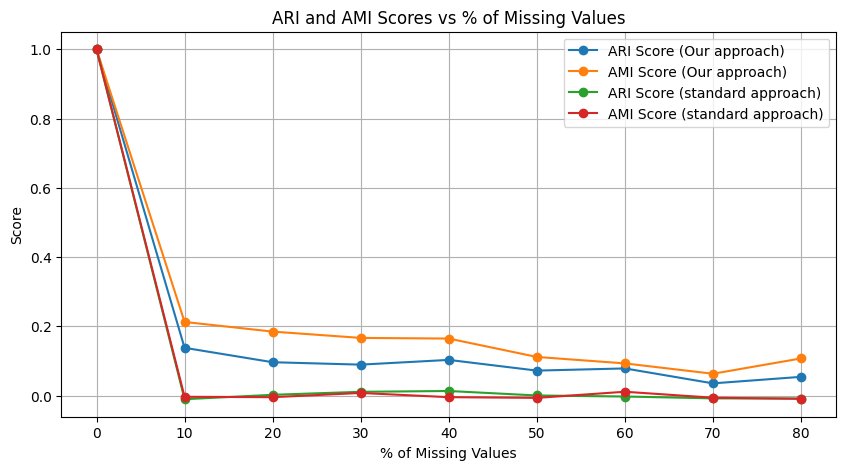

In [ ]:
# Create a single plot with both ARI and AMI scores
plt.figure(figsize=(10, 5))

# Plot ARI scores for spectral_clustering
plt.plot(percentages, ari_scores, marker='o', label='ARI Score (Our approach)')

# Plot AMI scores for spectral_clustering
plt.plot(percentages, ami_scores, marker='o', label='AMI Score (Our approach)')

# Plot ARI scores for spectral_clustering_vs
plt.plot(percentages, ari_scores_vs, marker='o', label='ARI Score (standard approach)')

# Plot AMI scores for spectral_clustering_vs
plt.plot(percentages, ami_scores_vs, marker='o', label='AMI Score (standard approach)')

plt.xlabel('% of Missing Values')
plt.ylabel('Score')
plt.title('ARI and AMI Scores vs % of Missing Values')
plt.legend()
plt.grid()

plt.show()